In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import pylab as plt
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import ensemble
from pylab import rcParams
from sklearn.decomposition import TruncatedSVD

## Training set

In [2]:
#for i in range(9,18,1):
 #   if i == 9:
  #      train = pd.read_csv('reg_pbp_200'+str(i)+'.csv')
   # else:
    #    df = pd.read_csv('reg_pbp_20'+str(i)+'.csv')
     #   train = pd.concat([train,df], axis=0)
validation = pd.read_csv('reg_pbp_2018.csv')
test = pd.read_csv('reg_pbp_2019.csv')



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (42,167,168,169,170,179,180,183,184,189,190,191,192,199,200,201,202,203,204,205,206,208,210,212,227,228,229,230,231,232,233,234,235,237,238,239,241,242,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (167,168,175,176,189,190,191,192,199,200,227,228,240) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
s = test.groupby('game_id')['play_id'].count()
avg_plays_in_game = s.sum()/s.shape[0]
avg_plays_in_game

178.30864197530863

In [38]:
train.shape[1]

263

On average, 178 plays are played in a regualr season game. An offensive team usually has 5 options for a play --
They can pass, run, attempt a filed goal, Spike, throw the ball out of bounds or punt. Traditioanlly, he first 3 plays are either a pass or run by the offensive team. The 4th dowm play usually reults in two types of play, either a field goal or punt.

In [16]:
test.groupby('posteam')['game_id'].count()

posteam
ARI    954
ATL    861
BAL    871
BUF    857
CAR    891
CHI    833
CIN    864
CLE    846
DAL    872
DEN    841
DET    888
GB     860
HOU    871
IND    884
JAX    857
KC     920
LA     877
LAC    916
MIA    824
MIN    925
NE     913
NO     867
NYG    841
NYJ    814
OAK    815
PHI    892
PIT    813
SEA    912
SF     925
TB     931
TEN    823
WAS    739
Name: game_id, dtype: int64

In [3]:
def group_yards(yard):
    string = str(int(yard))
    if len(string) > 1:
        val = string[0]
        return val+'0-'+str((int(val)+1)*10)
    return '0-10'

def group_diff(yard):
    for i in range(-20,24,4):
        if yard <= i:
            return int(i)
    return 20

def total_t(row):
    if row['qtr'] == 5:
        return row['quarter_seconds_remaining']
    return row['quarter_seconds_remaining'] + (4 - row['qtr'])*900

def clean_datat(df):
    df = df.dropna(axis=0, subset=['down','posteam'])
    df['month'] = df['game_date'].apply(lambda x:x.split('-')[1])
    df['year'] = df['game_date'].apply(lambda x:x.split('-')[0])
    df['day'] = df['game_date'].apply(lambda x:x.split('-')[2])
    df = df[df['play_type'] != 'no_play']
    df['10yrdrange'] = df['yardline_100'].apply(group_yards) 
    df['score_5']  = df['score_differential'].apply(group_diff)
    df['minutes_remain'] = df['time'].apply(lambda x:int(x.split(':')[0]))
    df['total_time'] = df.apply(total_t, axis = 1)
    return df
    
    

In [4]:
#train  =clean_datat(train)
validation  =clean_datat(validation)
test  =clean_datat(test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [7]:
#test['yardline_100']

In [22]:
predictions = []
def basline(row):
    if row['down'] == 1.0:
        return 'run'
    elif row['down'] == 2.0 or row['down'] == 3.0:
        return 'pass'
    elif row['down'] == 4.0 and row['yardline_100'] > 50:
        return 'punt'
    else:
        return 'field_goal'
p = validation.apply(lambda x:basline(x), axis=1)

In [23]:
sum(p == validation['play_type'])/len(p)

0.5931319771065904

In [21]:
train['play_type'].value_counts()

pass          168810
run           120631
punt           21908
field_goal      8894
qb_kneel        3403
qb_spike         616
Name: play_type, dtype: int64

In [30]:
train[train['down'] == 4 & train['play_type'] == 'pass'] 

TypeError: cannot compare a dtyped [object] array with a scalar of type [bool]

https://www.rdocumentation.org/packages/nflscrapR/versions/1.4.0/topics/game_play_by_play

In [157]:
after_play_columns = ['sp','play_type','ydsnet', 'air_yards','yards_after_catch','qb_hit','play_type','yards_gained','field_goal_result',
                     ]
use_ful_col = ['10yrdrange','qtr','down','time','ydstogo','posteam','defteam','game_date','quarter_seconds_remaining','side_of_field',
              'yardline_100','goal_to_go','posteam_timeouts_remaining','defteam_timeouts_remaining','score_differential',
              'posteam_score','defteam_score',]
debate_ = ['no_score_prob',]

##### Percentage of play type in each down

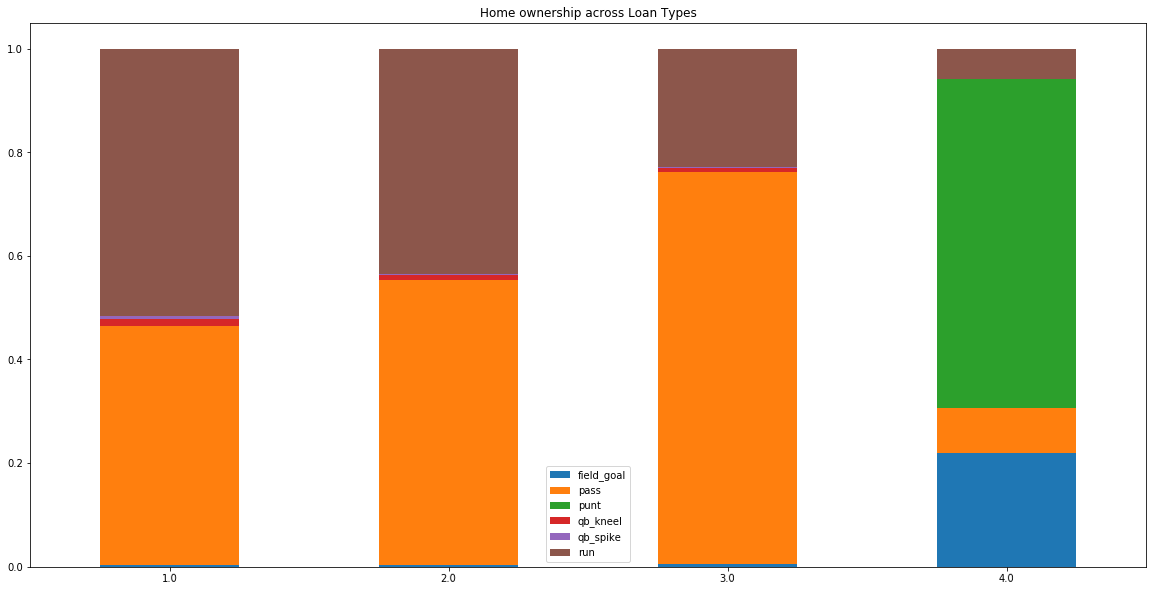

In [110]:
d = {}
for i in train['down'].value_counts().index:
    vals = train['play_type'][train['down'] == i].value_counts().to_dict()
    d[i] = (vals)
pt_down = pd.DataFrame(d).T
pt_down = pt_down.fillna(0)
pt_down  =pt_down.div(pt_down.sum(axis=1), axis=0)
pt_down.plot(kind='bar', stacked=True, rot=1, figsize=(20, 10),
               title="Home ownership across Loan Types")

In [ ]:
d = {}
for i in train['down'].value_counts().index:
    vals = train['play_type'][train['down'] == i].value_counts().to_dict()
    d[i] = (vals)
pt_down = pd.DataFrame(d).T
pt_down = pt_down.fillna(0)
pt_down  =pt_down.div(pt_down.sum(axis=1), axis=0)
pt_down.plot(kind='bar', stacked=True, rot=1, figsize=(20, 10),
               title="Home ownership across Loan Types")



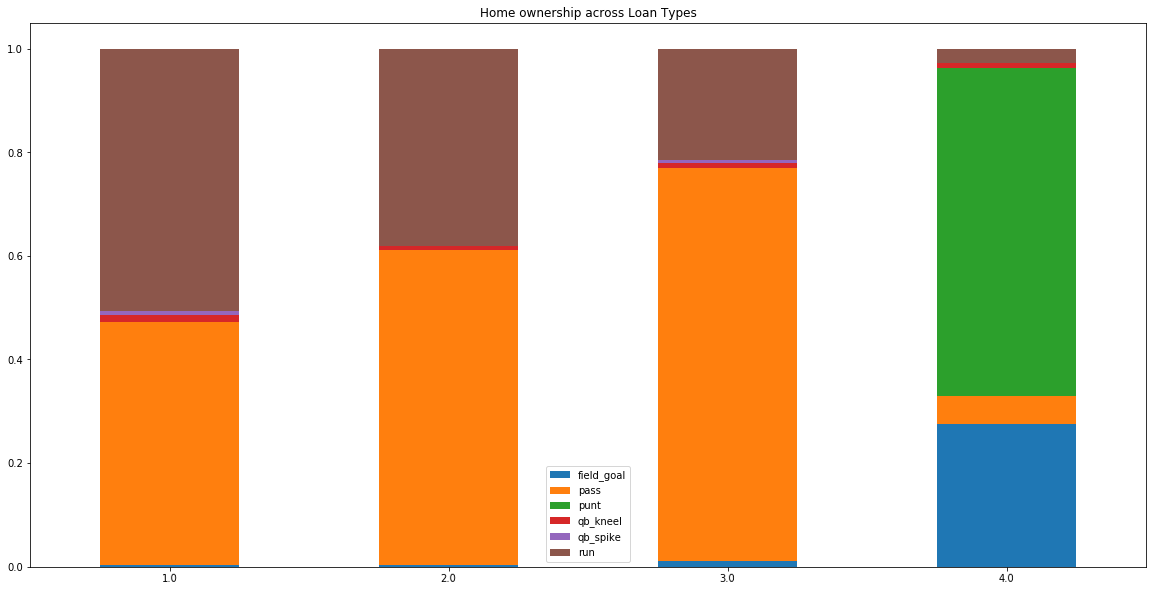

In [10]:
sf_ = validation[validation['posteam'] == 'SF']
#validation['posteam'].value_counts()
d = {}
for i in sf_['down'].value_counts().index:
    vals = sf_['play_type'][sf_['down'] == i].value_counts().to_dict()
    d[i] = (vals)
pt_down = pd.DataFrame(d).T
pt_down = pt_down.fillna(0)
pt_down  =pt_down.div(pt_down.sum(axis=1), axis=0)
pt_down.plot(kind='bar', stacked=True, rot=1, figsize=(20, 10),
               title="Home ownership across Loan Types")



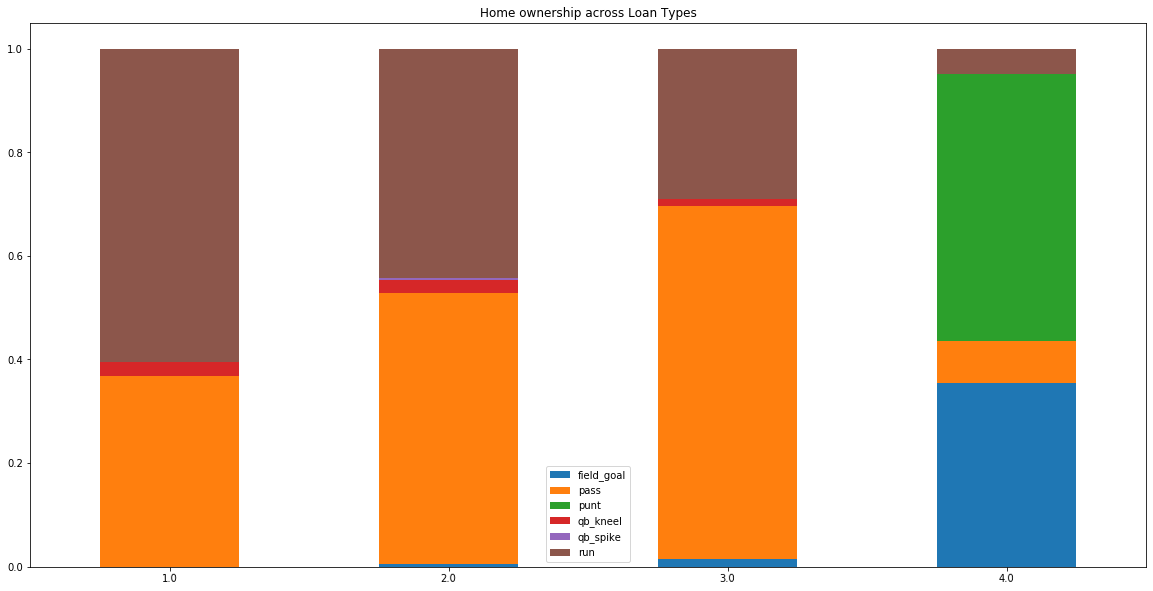

In [11]:
sf_ = test[test['posteam'] == 'SF']
#validation['posteam'].value_counts()
d = {}
for i in sf_['down'].value_counts().index:
    vals = sf_['play_type'][sf_['down'] == i].value_counts().to_dict()
    d[i] = (vals)
pt_down = pd.DataFrame(d).T
pt_down = pt_down.fillna(0)
pt_down  =pt_down.div(pt_down.sum(axis=1), axis=0)
pt_down.plot(kind='bar', stacked=True, rot=1, figsize=(20, 10),
               title="Home ownership across Loan Types")

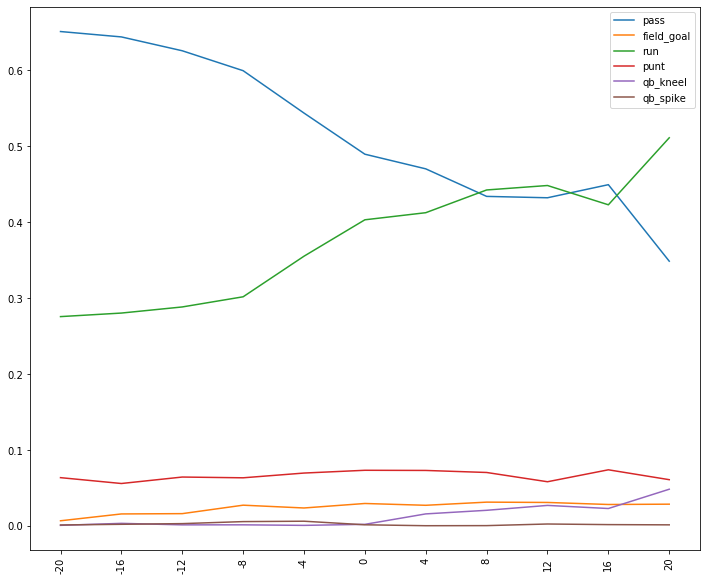

In [111]:
### from pylab import rcParams
d = {}
for i in train['play_type'].value_counts().index:
    vals = train['score_5'][train['play_type'] == i].values
    d[i] = vals
for i in d.keys():
    total = train['score_5'].value_counts().to_dict()
    count = pd.Series(d[i]).value_counts().to_dict()
    for j in count.keys():
        count[j] = count[j]/total[j]
    d[i] = count

x = [-20,-16,-12,-8,-4,0,4,8,12,16,20]
s = pd.Series(d['pass'])
plt.plot(pd.Series(d['pass']), label='pass')
plt.plot(pd.Series(d['field_goal']), label='field_goal')
plt.plot(pd.Series(d['run']),label='run')
plt.plot(pd.Series(d['punt']),label='punt')


plt.plot(pd.Series(d['qb_kneel']),label='qb_kneel')

plt.plot(pd.Series(d['qb_spike']),label='qb_spike')

plt.xticks(x, s.index, rotation='vertical')
plt.legend()

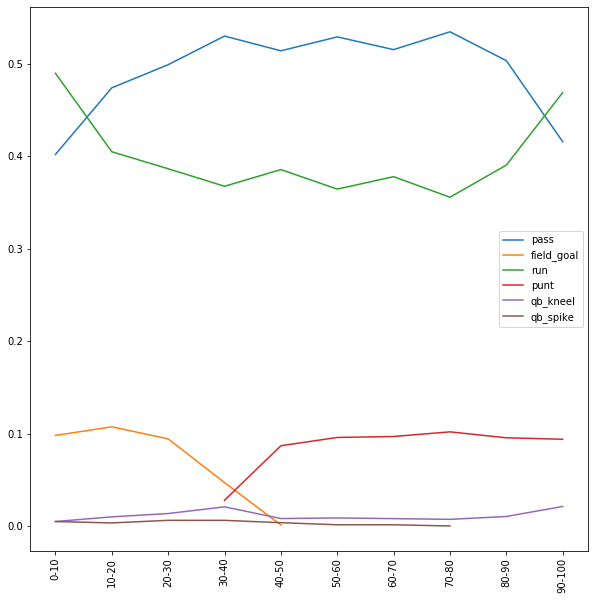

In [113]:
d = {}
for i in train['play_type'].value_counts().index:
    vals = train['10yrdrange'][train['play_type'] == i].values
    d[i] = vals
for i in d.keys():
    total = train['10yrdrange'].value_counts().to_dict()
    count = pd.Series(d[i]).value_counts().to_dict()
    for j in count.keys():
        count[j] = count[j]/total[j]
    d[i] = count
    
rcParams['figure.figsize'] = 10, 10
x = [0,1,2,3,4,5,6,7,8,9]
s = pd.Series(d['pass'])
plt.plot(pd.Series(d['pass']), label='pass')
plt.plot(pd.Series(d['field_goal']), label='field_goal')
plt.plot(pd.Series(d['run']),label='run')
plt.plot(pd.Series(d['punt']),label='punt')


plt.plot(pd.Series(d['qb_kneel']),label='qb_kneel')

plt.plot(pd.Series(d['qb_spike']),label='qb_spike')

plt.xticks(x, s.index, rotation='vertical')
plt.legend()

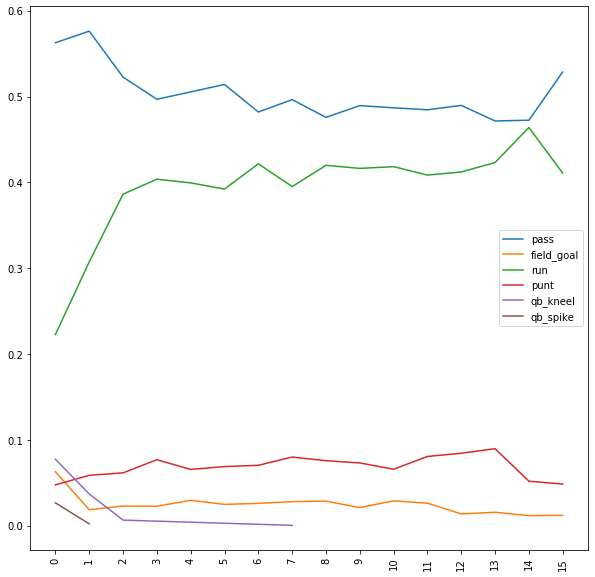

In [114]:

d = {}
for i in train['play_type'].value_counts().index:
    vals = train['minutes_remain'][train['play_type'] == i].values
    d[i] = vals
for i in d.keys():
    total = train['minutes_remain'].value_counts().to_dict()
    count = pd.Series(d[i]).value_counts().to_dict()
    for j in count.keys():
        count[j] = count[j]/total[j]
    d[i] = count
    
rcParams['figure.figsize'] = 10, 10
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
s = pd.Series(d['pass'])
plt.plot(pd.Series(d['pass']), label='pass')
plt.plot(pd.Series(d['field_goal']), label='field_goal')
plt.plot(pd.Series(d['run']),label='run')
plt.plot(pd.Series(d['punt']),label='punt')


plt.plot(pd.Series(d['qb_kneel']),label='qb_kneel')

plt.plot(pd.Series(d['qb_spike']),label='qb_spike')

plt.xticks(x, s.index, rotation='vertical')
plt.legend()

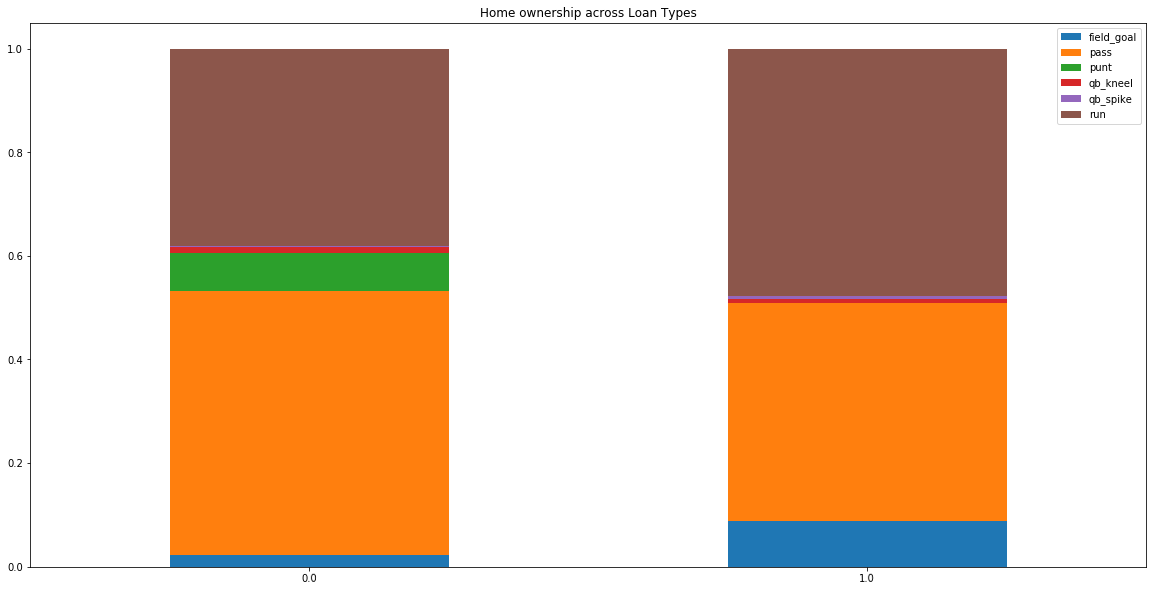

In [115]:
d = {}
for i in train['goal_to_go'].value_counts().index:
    vals = train['play_type'][train['goal_to_go'] == i].value_counts().to_dict()
    d[i] = (vals)
pt_down = pd.DataFrame(d).T
pt_down = pt_down.fillna(0)
pt_down  =pt_down.div(pt_down.sum(axis=1), axis=0)
pt_down.plot(kind='bar', stacked=True, rot=1, figsize=(20, 10),
               title="Home ownership across Loan Types")

In [116]:

use_ful_col = ['10yrdrange','score_5','minutes_remain','qtr','down','ydstogo','posteam','defteam','quarter_seconds_remaining',
              'yardline_100','goal_to_go','posteam_timeouts_remaining','defteam_timeouts_remaining','score_differential',
              'posteam_score','defteam_score','month','year','day','home_team','away_team','no_score_prob',
              'total_home_epa','total_away_epa','fg_prob','td_prob','ep','epa','total_home_epa',
               'total_away_epa','total_home_rush_epa',
                'total_away_rush_epa','total_home_pass_epa','total_away_pass_epa','wp','def_wp','home_wp','away_wp','wpa','total_time','shotgun',
              'no_huddle']
new_df = train[use_ful_col]
new_df1 = validation[use_ful_col]
test_df = test[use_ful_col]

In [117]:
def base_model(func):
    Variable_feautures = ['posteam_timeouts_remaining','defteam_timeouts_remaining','no_score_prob',
              'total_home_epa','total_away_epa','fg_prob','td_prob','ep','epa','total_home_epa',
               'total_away_epa','total_home_rush_epa',
                'total_away_rush_epa','total_home_pass_epa','total_away_pass_epa','wp','def_wp','home_wp','away_wp','wpa']

    categorical_feautures = ['quarter_seconds_remaining','posteam_score','defteam_score','posteam', 'defteam', 'month','year','day','qtr', 'down','goal_to_go',
                            '10yrdrange','score_5','minutes_remain','ydstogo','score_differential','yardline_100'
                            ,'home_team','away_team','shotgun','no_huddle']

## Prepare the data
    features = use_ful_col
    
    numeric_transformer = Pipeline(steps=[
        ('null_imputer', SimpleImputer(fill_value=0)),
        ('standard', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('null_string_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeriacl', numeric_transformer, Variable_feautures),
            ('categoral', categorical_transformer, categorical_feautures)])

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', func)])

    return clf

## Linear SVC 

In [88]:
#clf  = base_model(LinearSVC())
#clf.fit(new_df, boss_df['play_type'])
#pred = clf.predict(new_df1)
#sum(pred == df1['play_type'])/len(pred)

## SVC

In [ ]:
clf  = base_model(SVC())
clf.fit(new_df, boss_df['play_type'])
pred = clf.predict(new_df1)
sum(pred == df1['play_type'])/len(pred)

## Logistic regression

In [93]:

clf_L  = base_model(LogisticRegression(fit_intercept = True, C = 1))
clf_L.fit(new_df, boss_df['play_type'])
pred1 = clf_L.predict(new_df1)
(sum(pred1 == df1['play_type'])/len(pred1))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7436674788915963

In [94]:
pred_test = clf_L.predict(test_df)
(sum(pred_test == test['play_type'])/len(pred_test))


0.7485080609245569

In [31]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name
col_nam  = get_column_names_from_ColumnTransformer(clf_L.named_steps['preprocessor'])
li = list(zip(clf_L.named_steps['classifier'].coef_[0],col_nam))
li.sort()
li[10:]

NameError: name 'clf_L' is not defined

## Random Forest

In [806]:
clf  = base_model(RandomForestClassifier())
clf.fit(new_df, boss_df['play_type'])
pred1 = clf.predict(new_df1)
(sum(pred1 == df1['play_type'])/len(pred1))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6884172947243158

## MLP CLASSIFIER 

In [831]:
acti = ['identity', 'tanh', 'relu']
for i in acti:
    clf  = base_model(MLPClassifier(activation = i))
    clf.fit(new_df, boss_df['play_type'])
    pred1 = clf.predict(new_df1)
    print(i)
    print(sum(pred1 == df1['play_type'])/len(pred1))

identity
0.6448971496571655


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


tanh
0.6122003740012467


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


relu
0.6297954326514422


In [13]:
clf  = base_model(MLPClassifier(max_iter=1000))
clf.fit(new_df, boss_df['play_type'])
pred1 = clf.predict(new_df1)
print(i)
print(sum(pred1 == df1['play_type'])/len(pred1))

17
0.6448404828016093


## GBboost

In [23]:
gbr = ensemble.GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.02)
clf  = base_model(gbr)
clf.fit(new_df, boss_df['play_type'])
pred1 = clf.predict(new_df1)
print(sum(pred1 == df1['play_type'])/len(pred1))

0.7491358304527682


In [97]:
pred_test = clf.predict(test_df)
(sum(pred_test == test['play_type'])/len(pred_test))

0.7485080609245569

## Perfromace of model on diffrent teams

In [40]:
for_dic = {}
for i in test_df['posteam'].value_counts().index:
    pred_i = clf.predict(test_df[test_df['posteam'] == i])
    accu = sum(pred_i == test['play_type'][test['posteam']==i])/len(pred_i)
    for_dic[i] = accu
s = pd.Series(for_dic)
s = s.sort_values(ascending =False)


NameError: name 'test_df' is not defined

In [39]:
s

game_id
2019090500    173
2019090800    193
2019090801    177
2019090802    168
2019090803    171
2019090804    170
2019090805    181
2019090806    185
2019090807    166
2019090808    175
2019090809    236
2019090810    177
2019090811    174
2019090812    177
2019090900    179
2019090901    159
2019091200    185
2019091500    180
2019091501    184
2019091502    161
2019091503    181
2019091504    168
2019091505    174
2019091506    187
2019091507    180
2019091508    171
2019091509    168
2019091510    178
2019091511    184
2019091512    174
             ... 
2019110310    165
2019110311    179
2019110400    185
2019110700    173
2019111000    186
2019111001    158
2019111002    180
2019111003    180
2019111004    189
2019111005    181
2019111006    199
2019111007    178
2019111008    174
2019111009    201
2019111010    185
2019111100    219
2019111400    185
2019111700    167
2019111701    177
2019111702    182
2019111703    168
2019111704    188
2019111705    187
2019111706    177
20

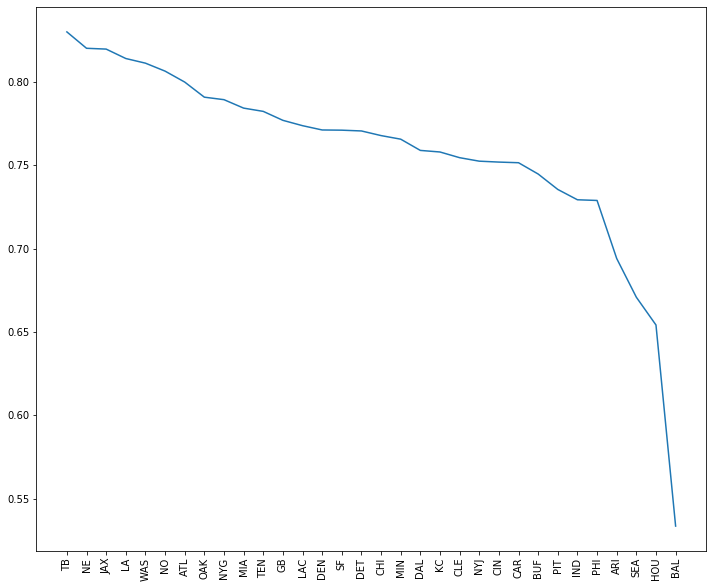

In [69]:
s.plot()
x = range(0,32,1)
plt.xticks(x, s.index, rotation='vertical')
rcParams['figure.figsize'] = 12, 10


In [122]:

find(pd.value_counts())

NameError: name 'find' is not defined